# Packages and libraries

In [326]:
import pandas as pd
import praw
import datetime 

#for fin bert
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
import re
from bs4 import BeautifulSoup
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
from official.nlp import optimization
import tqdm
tf.get_logger().setLevel('ERROR')

#for coin data extraction

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#!pip install ccxt seaborn pandas-datareader yfinance yahoofinancials
import seaborn as sns
import pandas_datareader as web
import yfinance as yf
from yahoofinancials import YahooFinancials
import time
from datetime import datetime, timedelta, date, time
import os
import datetime as dt

#transformers for time series

import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics


# Extracting Data from reddit and twitter

In [3]:
reddit = praw.Reddit(client_id='3G0jyGKEHepOgkb5v4X9eA', client_secret='3f4KXtYzChK9-_FU3DbbiNhrBSzBbg', user_agent='Rigor')

coins = ['Ethereum', 'Bitcoin', '']

for i in coins:
    subreddit = reddit.subreddit(i)
    posts= []
    
    start_date = '01-01-22 00:00:00'
    start_date = datetime.datetime.strptime(start_date, '%d-%m-%y %H:%M:%S').timestamp()
    for post in subreddit.new(limit=1000):
        date = post.created_utc
        if date > start_date:
            posts.append([post.selftext, post.created_utc])

    posts = pd.DataFrame(posts,columns=[ 'Body', 'Date'])
    posts['Date'] = pd.to_datetime(posts['Date'],  unit='s')
#print(posts)
    posts.to_csv('{}_reddit_extraction_101.csv'.format(i))



# NLP with FinBERT

In [3]:
# create a tokenizer object
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# fetch the pretrained model 
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [4]:
# A Body to be used as input 
Body = "Bitcoin is on the same price for the day"

# Pre-process input phrase
input = tokenizer(Body, padding = True, truncation = True, return_tensors='pt')
# Run inference on the tokenized phrase
output = model(**input)

# Pass model output logits through a softmax layer.
sentim_scores = torch.nn.functional.softmax(output.logits, dim=-1)

In [5]:
def sentim_analyzer(df, tokenizer, model):
    for i in range (0, len(df)) :
        try:
            Body = df.loc[i, 'Body']
        except:
            return print(' \'Body\' column might be missing from dataframe')
        
        # Pre-process input phrase
        input = tokenizer(Body, padding = True, truncation = True, return_tensors='pt')
        # Estimate output
        output = model(**input)
        # Pass model output logits through a softmax layer.
        predictions = torch.nn.functional.softmax(output.logits, dim=-1)
        df.loc[i, 'Positive'] = predictions[0][0].tolist()
        df.loc[i, 'Negative'] = predictions[0][1].tolist()
        df.loc[i, 'Neutral']  = predictions[0][2].tolist()
    # rearrange column order
    try:
        df = df[['Date',  'Body', 'Positive', 'Negative', 'Neutral']]
    except:
        pass
    return df

In [11]:
coins = ['Ethereum','Cardano', 'Polkadot']
for i in coins:
    data = pd.read_csv('{}_reddit_extraction_101.csv'.format(i))
    data = data.dropna()
    data = data.drop(["Unnamed: 0"],axis=1)
    data = data.reset_index()
    #data['Body'] = data['Body'].astype(str)
    
    sentim_data = sentim_analyzer(data, tokenizer, model)
    
    # sentiment Between 0 and 1
    
    sentim_data["Score"] = (sentim_data["Positive"] + 0.5*sentim_data["Neutral"]) / (sentim_data["Positive"]+ sentim_data["Neutral"]+ sentim_data["Negative"])
    
    sentim_data['Date'] = pd.to_datetime(sentim_data['Date']).dt.date
    sentim_data = sentim_data.groupby('Date')['Score'].mean()
    sentim_data.to_csv("final_sentiment_score_{}_101.csv".format(i))



# Extracting Coin Data from Yahoo Finance

In [219]:
coins = ["ETH-USD","ADA-USD","DOT-USD"]

close_list = []

d0 = date(2023, 5, 17)
d1 = date(2022, 1, 1)
days = abs(d0-d1).days+1

for i in coins:
    yahoo_financials = YahooFinancials(i) # gets data of coin from yahoo api
    data=yahoo_financials.get_historical_price_data("2022-01-01", "2023-05-17", "daily") #gets daily data from 2019 - 2023  
    
    df = pd.DataFrame(data[i]['prices']) #prices column of the coin
    zero_padding_len = days - len(df)
    zero_padding = pd.DataFrame(np.zeros(zero_padding_len, dtype=float))
    df = pd.concat([zero_padding, df])
    close_list.append(df["close"]) #adds close data of each coin in close_list


In [220]:
close_list = np.array(close_list)
close_list[pd.isna(close_list)] = 0

In [221]:
def get_digits(num):
    count = 0
    while(num > 0):
        num = num//10
        count = count + 1
    return count

def normalize(coin_list): #gets a single coin's prices
    max_num = coin_list.max()
    max_len_max_price = get_digits(max_num)
    return coin_list/10**max_len_max_price

In [222]:
#print(len(close_list))
for i in range (0, len(close_list)):
    close_list[i] = normalize(close_list[i])

In [223]:
close_list = close_list.T
close_df = pd.DataFrame(close_list, columns = coins)

In [224]:
dates = []
start_date = "2022-01-01"
for i in range(0,len(close_list)):
    dates.append(pd.to_datetime(start_date)+timedelta(i))

close_df["dates"] = dates    
close_df.to_csv("close_prices_101.csv")

In [225]:
close_df

,ETH-USD,ADA-USD,DOT-USD,dates
0,0.376970,0.137698,0.285836,2022-01-01
1,0.382956,0.137758,0.297312,2022-01-02
2,0.376138,0.132164,0.301051,2022-01-03
3,0.379406,0.131166,0.287777,2022-01-04
4,0.355039,0.123600,0.267961,2022-01-05
...,...,...,...,...
497,0.179611,0.036503,0.053519,2023-05-13
498,0.180050,0.037076,0.053544,2023-05-14
499,0.181755,0.036748,0.053203,2023-05-15
500,0.182412,0.036783,0.052993,2023-05-16


# Pre-processing the data for training

In [273]:
price_data = pd.read_csv('close_prices_101.csv')

In [274]:
price_data.head()

,Unnamed: 0,ETH-USD,ADA-USD,DOT-USD,dates
0,0,0.376970,0.137698,0.285836,2022-01-01
1,1,0.382956,0.137758,0.297312,2022-01-02
2,2,0.376138,0.132164,0.301051,2022-01-03
3,3,0.379406,0.131166,0.287777,2022-01-04
4,4,0.355039,0.123600,0.267961,2022-01-05


In [275]:
coin_price_data = pd.DataFrame(price_data["ADA-USD"]) #df for particular coin price
#adding dates to the column
dates = pd.DataFrame(price_data["dates"])
coin_price_data = coin_price_data.join(dates)

In [276]:
coin_price_data

,ADA-USD,dates
0,0.137698,2022-01-01
1,0.137758,2022-01-02
2,0.132164,2022-01-03
3,0.131166,2022-01-04
4,0.123600,2022-01-05
...,...,...
497,0.036503,2023-05-13
498,0.037076,2023-05-14
499,0.036748,2023-05-15
500,0.036783,2023-05-16


# Adding volume feature

In [277]:
#Adding the volume feature in the data set

# Replace "BTC-USD" with the ticker symbol of the cryptocurrency you want to analyze
ticker = yf.Ticker("ADA-USD")

# Set the start and end date of the date range
d0 = date(2023, 1, 2)
d1 = date(2021, 1, 1)

# Get the historical market data for the date range
history = ticker.history(start=d1, end=d0)

# Extract the trading volume for each day
volume = history['Volume']

# Print the trading volume for each day
#print(volume)
volume = pd.DataFrame(volume)
volume

,Volume
Date,
2021-01-01 00:00:00+00:00,1122218004
2021-01-02 00:00:00+00:00,1408849504
2021-01-03 00:00:00+00:00,2303857909
2021-01-04 00:00:00+00:00,3260699086
2021-01-05 00:00:00+00:00,4097207384
...,...
2022-12-28 00:00:00+00:00,209596269
2022-12-29 00:00:00+00:00,214425739
2022-12-30 00:00:00+00:00,159952057


In [278]:
volume_coin = np.array(volume['Volume'])
volume_coin

array([ 1122218004,  1408849504,  2303857909,  3260699086,  4097207384,
        6170988900,  5149188552,  4560690774,  3655608662,  3732911206,
        4768803200,  4037298875,  2656935144,  2686785564,  3171984602,
        4476161885,  5617481334,  3480282508,  2957453653,  3281600988,
        3567902823,  4066222238,  2781033956,  2539663711,  2339817092,
        2557745015,  2666764973,  2863036709,  3367098095,  2866173269,
        2455679992,  3838085989,  6504904709,  3648896567,  3553059568,
        6808411307,  8109402422, 11252055620,  9056514741,  5885048712,
       12667653585, 10627183208,  8035829513,  7532474270,  7159401195,
        8979888270,  6948621246,  5841828077,  4918032802,  4582877243,
       11454890463,  7042361464, 10562051439, 11201900117,  8481334623,
        8248286269, 14884142109, 19141980288, 15732556180,  9775330113,
        8118255106,  4937160429,  7164490225,  7325099027,  5348048001,
        4204795554,  3557114310,  5317733185,  4215428913,  3633

In [279]:
def get_digits(num):
    count = 0
    while num > 0:
        num = num // 10
        count += 1
    return count

def normalize(coin_list):
    max_num = coin_list.max()
    max_len_max_price = get_digits(max_num)
    return coin_list / (10 ** max_len_max_price)

# Normalizing the volume
volume_coin = volume['Volume'].copy()  # Create a copy of the volume['Volume'] column

volume_coin_normalized = normalize(volume_coin)
volume_coin_normalized = pd.DataFrame(volume_coin_normalized)

In [280]:
volume_coin_normalized = volume_coin_normalized.reset_index()
volume_coin_normalized

,Date,Volume
0,2021-01-01 00:00:00+00:00,0.011222
1,2021-01-02 00:00:00+00:00,0.014088
2,2021-01-03 00:00:00+00:00,0.023039
3,2021-01-04 00:00:00+00:00,0.032607
4,2021-01-05 00:00:00+00:00,0.040972
...,...,...
726,2022-12-28 00:00:00+00:00,0.002096
727,2022-12-29 00:00:00+00:00,0.002144
728,2022-12-30 00:00:00+00:00,0.001600
729,2022-12-31 00:00:00+00:00,0.001441


In [281]:
coin_price_data.rename(columns={'ADA-USD':'close_ADA'}, inplace = True)
coin_price_data['previous_close_ADA'] = coin_price_data['close_ADA'].shift(1) #filling a new column with price of previous day (open for current day)

# drop rows with NaN values
coin_price_data.dropna(inplace=True)

In [282]:
coin_price_data['previous_volume_ADA'] = volume_coin_normalized['Volume']

In [283]:
coin_price_data = coin_price_data.dropna()

In [284]:
coin_price_data

,close_ADA,dates,previous_close_ADA,previous_volume_ADA
1,0.137758,2022-01-02,0.137698,0.014088
2,0.132164,2022-01-03,0.137758,0.023039
3,0.131166,2022-01-04,0.132164,0.032607
4,0.123600,2022-01-05,0.131166,0.040972
5,0.127978,2022-01-06,0.123600,0.061710
...,...,...,...,...
497,0.036503,2023-05-13,0.037046,0.019461
498,0.037076,2023-05-14,0.036503,0.011787
499,0.036748,2023-05-15,0.037076,0.010904
500,0.036783,2023-05-16,0.036748,0.012917


In [285]:
sentiment_score = pd.read_csv("final_sentiment_score_Cardano_101.csv") #importing sentiment data

In [286]:
coin_final_data = coin_price_data.join(sentiment_score['Score'])

In [287]:
coin_final_data.sort_values(by="dates")

,close_ADA,dates,previous_close_ADA,previous_volume_ADA,Score
1,0.137758,2022-01-02,0.137698,0.014088,0.476089
2,0.132164,2022-01-03,0.137758,0.023039,0.375661
3,0.131166,2022-01-04,0.132164,0.032607,0.463329
4,0.123600,2022-01-05,0.131166,0.040972,0.524374
5,0.127978,2022-01-06,0.123600,0.061710,0.464877
...,...,...,...,...,...
497,0.036503,2023-05-13,0.037046,0.019461,NaN
498,0.037076,2023-05-14,0.036503,0.011787,NaN
499,0.036748,2023-05-15,0.037076,0.010904,NaN
500,0.036783,2023-05-16,0.036748,0.012917,NaN


In [288]:
coin_final_data.rename(columns={'Score':'sentiment_ADA'}, inplace = True)
coin_final_data = coin_final_data[['dates','previous_close_ADA','close_ADA','sentiment_ADA','previous_volume_ADA']]
coin_final_data.head()

,dates,previous_close_ADA,close_ADA,sentiment_ADA,previous_volume_ADA
1,2022-01-02,0.137698,0.137758,0.476089,0.014088
2,2022-01-03,0.137758,0.132164,0.375661,0.023039
3,2022-01-04,0.132164,0.131166,0.463329,0.032607
4,2022-01-05,0.131166,0.123600,0.524374,0.040972
5,2022-01-06,0.123600,0.127978,0.464877,0.061710


In [289]:
coin_final_data=coin_final_data.dropna()

In [290]:
coin_final_data.to_csv('final_training_data_cardano_101.csv')

In [291]:
coin_final_data

,dates,previous_close_ADA,close_ADA,sentiment_ADA,previous_volume_ADA
1,2022-01-02,0.137698,0.137758,0.476089,0.014088
2,2022-01-03,0.137758,0.132164,0.375661,0.023039
3,2022-01-04,0.132164,0.131166,0.463329,0.032607
4,2022-01-05,0.131166,0.123600,0.524374,0.040972
5,2022-01-06,0.123600,0.127978,0.464877,0.061710
...,...,...,...,...,...
75,2022-03-17,0.083837,0.083678,0.455316,0.100465
76,2022-03-18,0.083678,0.085343,0.551775,0.113928
77,2022-03-19,0.085343,0.090110,0.471343,0.079703
78,2022-03-20,0.090110,0.087709,0.531551,0.043170


# Understanding Data by Visualization

In [321]:
df = pd.read_csv("final_training_data_polkadot_101.csv")

In [322]:
df.head()

,Unnamed: 0,dates,previous_close_DOT,close_DOT,sentiment_DOT,previous_volume_DOT
0,1,2022-01-02,0.285836,0.297312,0.516406,0.030492
1,2,2022-01-03,0.297312,0.301051,0.492213,0.030329
2,3,2022-01-04,0.301051,0.287777,0.510017,0.028933
3,4,2022-01-05,0.287777,0.267961,0.519474,0.020807
4,5,2022-01-06,0.267961,0.267608,0.528796,0.023825


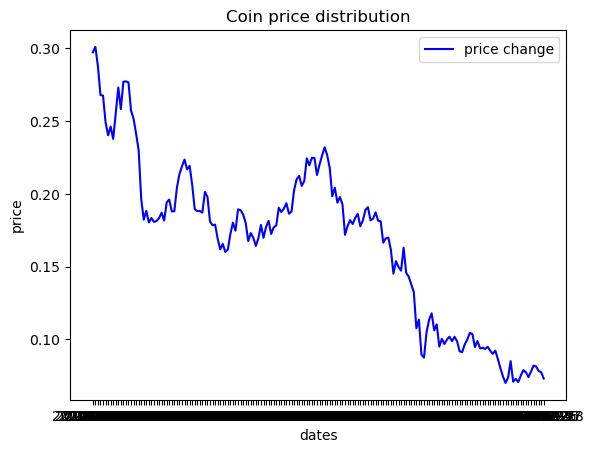

In [323]:
x= df['dates']
y = df['close_DOT']
v = df['previous_volume_DOT']
plt.plot(x, y, label = 'price change', c = 'b')
plt.xlabel('dates')
plt.ylabel('price')
plt.legend(loc='upper right')


plt.title('Coin price distribution')
plt.show()

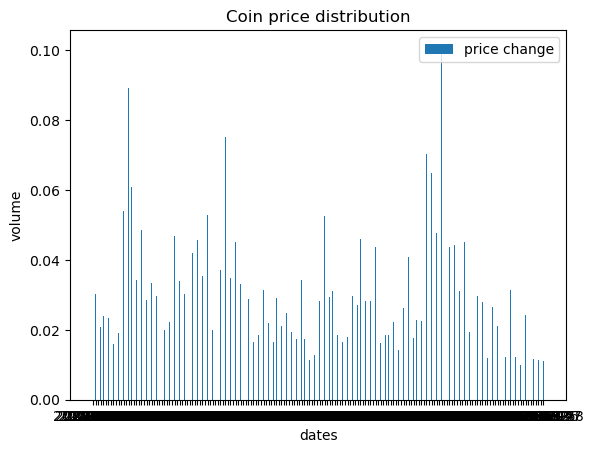

In [324]:
x= df['dates']
y = df['close_DOT']
v = df['previous_volume_DOT']
bins = 700
plt.bar(x,v, width =0.2, label = 'price change')
plt.xlabel('dates')
plt.ylabel('volume')
plt.legend(loc='upper right')

plt.title('Coin price distribution')
plt.show()

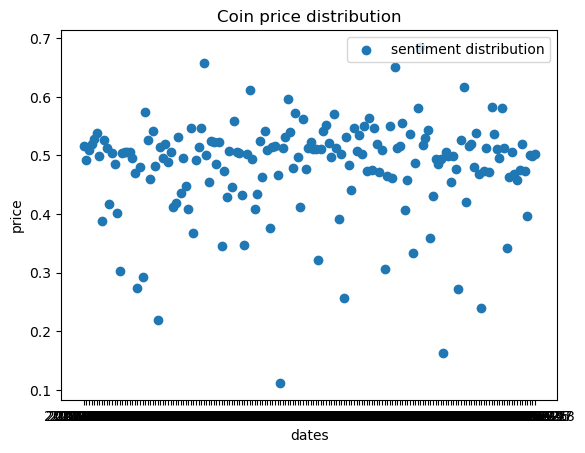

In [325]:

x= df['dates']
y = df['close_DOT']
s = df['sentiment_DOT']
plt.scatter(x, s, label = 'sentiment distribution')
plt.xlabel('dates')
plt.ylabel('price')
plt.legend(loc='upper right')

plt.title('Coin price distribution')
plt.show()

In [347]:
df = pd.read_csv('final_training_data_cardano_101.csv')

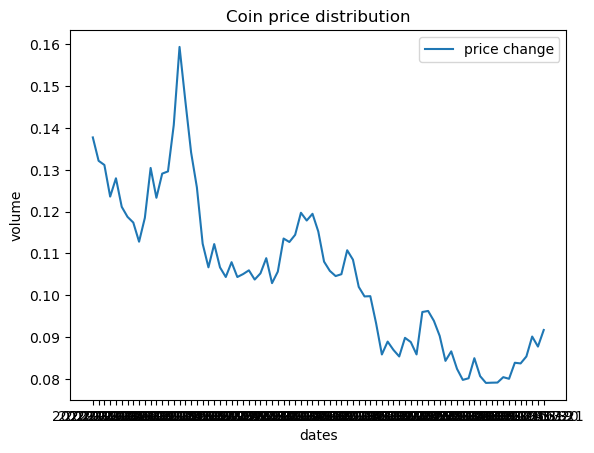

In [345]:
x= df['dates']
y = df['close_ADA']
v = df['previous_volume_ADA']
bins = 700
plt.plot(x,y, label = 'price change')
plt.xlabel('dates')
plt.ylabel('volume')
plt.legend(loc='upper right')

plt.title('Coin price distribution')
plt.show()

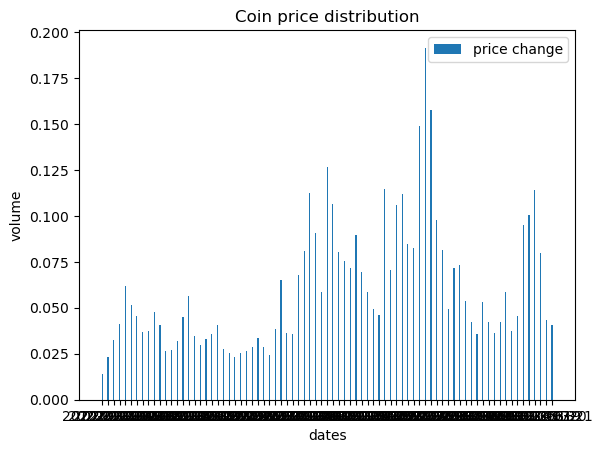

In [330]:
x= df['dates']
y = df['close_ADA']
v = df['previous_volume_ADA']
bins = 700
plt.bar(x,v, width =0.2, label = 'price change')
plt.xlabel('dates')
plt.ylabel('volume')
plt.legend(loc='upper right')

plt.title('Coin price distribution')
plt.show()

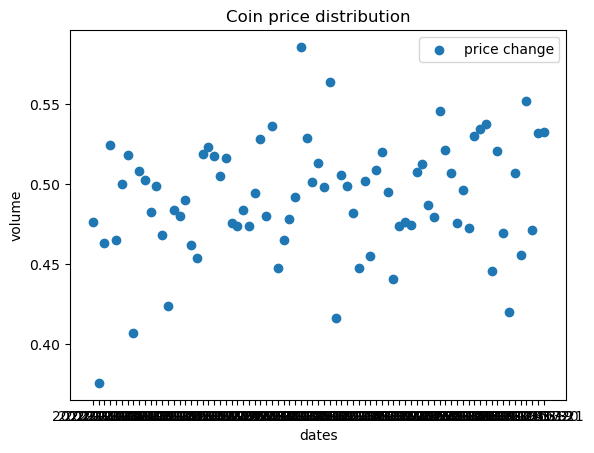

In [350]:
x= df['dates']
y = df['close_ADA']
v = df['previous_volume_ADA']
s = df['sentiment_ADA']
bins = 700
plt.scatter(x,s, label = 'price change')
plt.xlabel('dates')
plt.ylabel('volume')
plt.legend(loc='upper right')

plt.title('Coin price distribution')
plt.show()

In [351]:
df = pd.read_csv('ethereum_final_training_data2.csv')
df

,Unnamed: 0,dates,sentiment,pre_volu_eth,close_eth,previous_close_eth
0,1,2021-01-02,0.129833,0.197408,0.774535,0.730368
1,2,2021-01-03,0.233337,0.452005,0.975508,0.774535
2,3,2021-01-04,0.490335,0.569460,0.104023,0.975508
3,4,2021-01-05,0.503548,0.415359,0.110001,0.104023
4,5,2021-01-06,0.567268,0.446999,0.120711,0.110001
...,...,...,...,...,...,...
725,726,2022-12-28,0.526710,0.499167,0.118999,0.121279
726,727,2022-12-29,0.458966,0.413223,0.120160,0.118999
727,728,2022-12-30,0.517215,0.405567,0.119923,0.120160
728,729,2022-12-31,0.495758,0.301851,0.119677,0.119923


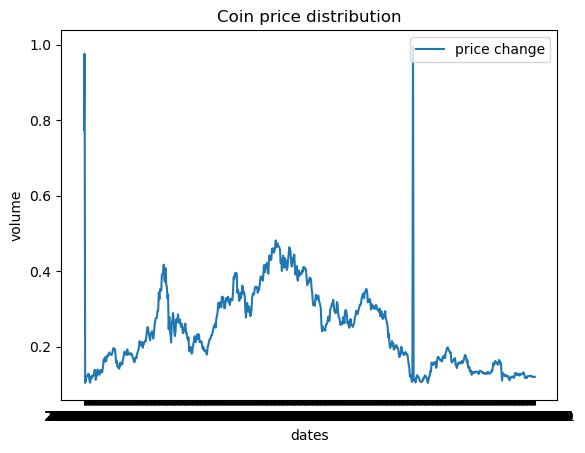

In [355]:
x= df['dates']
y = df['close_eth']
v = df['pre_volu_eth']
plt.plot(x,y, label = 'price change')
plt.xlabel('dates')
plt.ylabel('price')
plt.legend(loc='upper right')

plt.title('Coin price distribution')
plt.show()

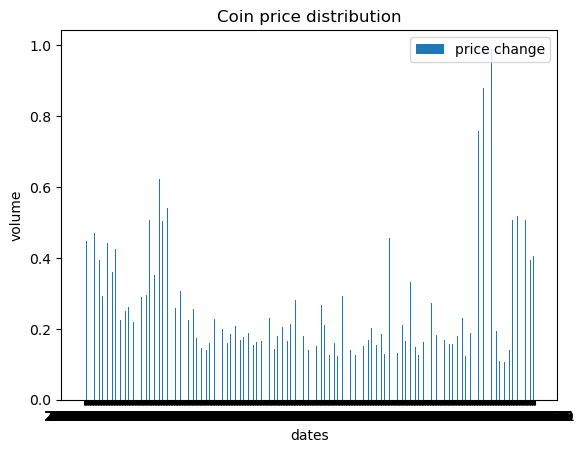

In [353]:
x= df['dates']
y = df['close_eth']
v = df['pre_volu_eth']
bins = 700
plt.bar(x,v, width =0.2, label = 'price change')
plt.xlabel('dates')
plt.ylabel('volume')
plt.legend(loc='upper right')

plt.title('Coin Volume distribution')
plt.show()

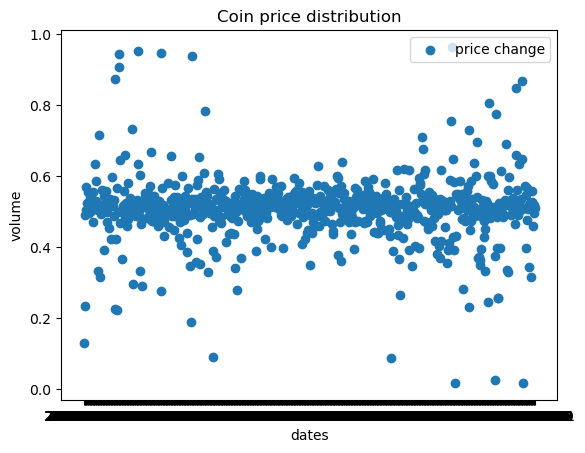

In [356]:
x= df['dates']
y = df['close_eth']
v = df['pre_volu_eth']
s = df['sentiment']
bins = 700
plt.scatter(x,s, label = 'price change')
plt.xlabel('dates')
plt.ylabel('volume')
plt.legend(loc='upper right')

plt.title('Coin sentiment distribution')
plt.show()

# Final Model Training with Transformers for Time series

In [406]:
#importing final data
eth = pd.read_csv('ethereum_final_training_data2.csv')
ada = pd.read_csv('final_training_data_cardano_101.csv')
dot = pd.read_csv('final_training_data_polkadot_101.csv')

#changing column name
ada = ada.rename(columns={'close_ADA': 'close', 'previous_close_ADA':'pre_close', 'sentiment_ADA':'sentiment','previous_volume_ADA':'pre_volume'})
dot = dot.rename(columns={'close_DOT': 'close', 'previous_close_DOT':'pre_close', 'sentiment_DOT':'sentiment','previous_volume_DOT':'pre_volume'})
eth = eth.rename(columns={'close_eth': 'close', 'previous_close_eth':'pre_close', 'sentiment':'sentiment','pre_volu_eth':'pre_volume'})

#droping unwanted data
ada = ada.drop(['dates'], axis =1)
eth = eth.drop(['dates'], axis =1)
dot = dot.drop(['dates'], axis =1)

#appending to form one data frame
combined_data = eth.append(ada)
combined_data = combined_data.append(dot)
combined_data = combined_data.drop(['Unnamed: 0'], axis = 1)

In [433]:
#df['sn_value'] = df['sn_value'].astype(float)
'''
df = pd.read_csv("ethereum_final_training_data2.csv")


df['dates'] = pd.to_datetime(df['dates'], format='%Y/%m/%d')

# Filter data by date
start_date = pd.to_datetime('2022-01-01')
end_date = pd.to_datetime('2022-08-01')

df_train = df[df['dates'] < end_date]
df_test = df[df['dates'] >= end_date]
'''
df_train = combined_data.iloc[:700]  # Select the first 700 rows
df_test = combined_data.iloc[700:]  # Select rows starting from index 700

#start here
spots_train = df_train['close'].tolist()
spots_test = df_test['close'].tolist()

print("Training set has {} observations.".format(len(spots_train)))
print("Test set has {} observations.".format(len(spots_test)))

Training set has 700 observations.
Test set has 287 observations.


In [434]:
#dates = df['dates'] #storing dates in list

#df = df.drop(columns=['Unnamed: 0', 'dates'], axis= 1) #droping dates and unamed column

#df

,predicted_price,actual_price
date,,
2021-01-02,0.199172,0.169166
2021-01-03,0.191035,0.169935
2021-01-04,0.207541,0.177552
2021-01-05,0.200357,0.170303
2021-01-06,0.191658,0.185174
...,...,...
2021-05-26,0.180372,0.118999
2021-05-27,0.180510,0.120160
2021-05-28,0.180309,0.119923


In [435]:
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
    
    
SEQUENCE_SIZE = 5
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (695, 5, 1)
Shape of test set: (282, 5, 1)


In [436]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [437]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [438]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

Epoch 1/200
9/9 [==============================] - 6s 136ms/step - loss: 0.0885 - val_loss: 0.0226
Epoch 2/200
9/9 [==============================] - 1s 69ms/step - loss: 0.0871 - val_loss: 0.0219
Epoch 3/200
9/9 [==============================] - 1s 68ms/step - loss: 0.0850 - val_loss: 0.0215
Epoch 4/200
9/9 [==============================] - 1s 69ms/step - loss: 0.0860 - val_loss: 0.0212
Epoch 5/200
9/9 [==============================] - 1s 70ms/step - loss: 0.0846 - val_loss: 0.0209
Epoch 6/200
9/9 [==============================] - 1s 73ms/step - loss: 0.0836 - val_loss: 0.0206
Epoch 7/200
9/9 [==============================] - 1s 69ms/step - loss: 0.0823 - val_loss: 0.0203
Epoch 8/200
9/9 [==============================] - 1s 69ms/step - loss: 0.0806 - val_loss: 0.0199
Epoch 9/200
9/9 [==============================] - 1s 70ms/step - loss: 0.0794 - val_loss: 0.0194
Epoch 10/200
9/9 [==============================] - 1s 71ms/step - loss: 0.0786 - val_loss: 0.0190
Epoch 11/200
9/9 [

0.0017820002976804972

In [439]:
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

9/9 [==============================] - 1s 10ms/step
Score (RMSE): 0.042213744486423475


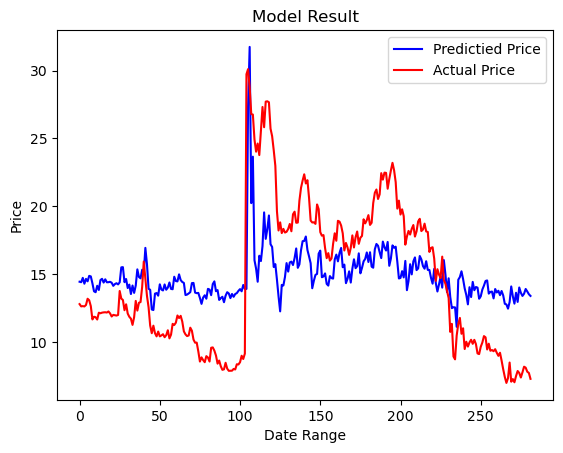

In [446]:
indices = range(len(pred))
plt.plot(indices,pred*100,label='Predictied Price', color = 'b')
plt.plot(indices,y_test*100,label= 'Actual Price', color = 'red')
plt.xlabel('Date Range')
plt.ylabel('Price')
plt.title("Model Result")
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
'''

# Convert dates to pandas datetime object
dates = pd.to_datetime(dates)

# Filter the dates array to only include dates with predictions and actual values
dates = dates[:len(pred)]

# Create a pandas dataframe with the predicted and actual prices and the filtered dates
df = pd.DataFrame({'date': dates, 'predicted_price': pred.reshape(-1), 'actual_price': y_test.reshape(-1)})

# Set the "date" column as the index of the dataframe
df.set_index('date', inplace=True)

# Plot the predicted and actual prices using matplotlib




plt.plot(df.index, df['predicted_price']*10000, label='Predicted Price')
plt.plot(df.index, df['actual_price']*10000, label='Actual Price')

# Add x-axis label and titl
plt.xlabel('Date')
plt.title('Predicted vs Actual Price')

# Add legend and show the plot
plt.legend()
plt.show()

'''